# OceanHackWeek 2020 Operational Data Insights

Putting Prometheus and Grafana on the hackweek's kubernetes cluster was a great idea as it allowed me to see some easy visualizations for cluster health. There is also the benefit of being able to export data from Grafana dashboards to analyze in Pandas. It would be nice to export the data from Prometheus itself, as I have now realized that about two weeks of data is the maximum that Prometheus will save for the setup of this cluster. The export for the data used here was just under two weeks past the start of the hackweek, so it is the only data of its kind that we have for this hackweek.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

sns.set(style="darkgrid")

%matplotlib inline

ModuleNotFoundError: No module named 'matplotlib'

In [5]:
pod_mem_csv_file = "~/Documents/hackweek-reports/ohw/ohw-mem-data.csv"
pod_cpu_csv_file = "~/Documents/hackweek-reports/ohw/ohw-cpu-data-10m.csv"

## Memory

Examine the data

In [6]:
pod_mem_df = pd.read_csv(pod_mem_csv_file)
pod_mem_df.head()

,"Series;""Time"";""Value"""
0,"aws-node-termination-handler-dd8v2;""2020-08-08..."
1,"aws-node-termination-handler-dd8v2;""2020-08-08..."
2,"aws-node-termination-handler-dd8v2;""2020-08-08..."
3,"aws-node-termination-handler-dd8v2;""2020-08-08..."
4,"aws-node-termination-handler-dd8v2;""2020-08-08..."


In [7]:
pod_mem_df.tail().values

array([['jupyter-cooleyky;"2020-08-22T04:30:00-07:00";null'],
       ['jupyter-cooleyky;"2020-08-22T04:45:00-07:00";null'],
       ['jupyter-cooleyky;"2020-08-22T05:00:00-07:00";null'],
       ['jupyter-cooleyky;"2020-08-22T05:15:00-07:00";null'],
       ['jupyter-cooleyky;"2']], dtype=object)

Looks like the data is formatted as "pod name";"timestamp";"value"

In [8]:
pod_mem_df.columns

Index(['Series;"Time";"Value"'], dtype='object')

In [9]:
pod_mem_df.iloc[0,0]

'aws-node-termination-handler-dd8v2;"2020-08-08T12:00:00-07:00";null'

Since this data is just a long string, we need to convert it into 3 columns and make them usable. 

Prototype conversion below

In [10]:
split_test_df = pod_mem_df.iloc[0:5,0].str.split(";", expand=True)
split_test_df

,0,1,2
0,aws-node-termination-handler-dd8v2,"""2020-08-08T12:00:00-07:00""",null
1,aws-node-termination-handler-dd8v2,"""2020-08-08T12:15:00-07:00""",null
2,aws-node-termination-handler-dd8v2,"""2020-08-08T12:30:00-07:00""",null
3,aws-node-termination-handler-dd8v2,"""2020-08-08T12:45:00-07:00""",null
4,aws-node-termination-handler-dd8v2,"""2020-08-08T13:00:00-07:00""",null


In [11]:
split_test_df.columns = ["pod", "time", "memory"]
split_test_df

,pod,time,memory
0,aws-node-termination-handler-dd8v2,"""2020-08-08T12:00:00-07:00""",null
1,aws-node-termination-handler-dd8v2,"""2020-08-08T12:15:00-07:00""",null
2,aws-node-termination-handler-dd8v2,"""2020-08-08T12:30:00-07:00""",null
3,aws-node-termination-handler-dd8v2,"""2020-08-08T12:45:00-07:00""",null
4,aws-node-termination-handler-dd8v2,"""2020-08-08T13:00:00-07:00""",null


In [12]:
split_test_df.loc[:,"time"] = [value[1:][:-7] for value in split_test_df.loc[:, "time"]]
split_test_df

,pod,time,memory
0,aws-node-termination-handler-dd8v2,2020-08-08T12:00:00,null
1,aws-node-termination-handler-dd8v2,2020-08-08T12:15:00,null
2,aws-node-termination-handler-dd8v2,2020-08-08T12:30:00,null
3,aws-node-termination-handler-dd8v2,2020-08-08T12:45:00,null
4,aws-node-termination-handler-dd8v2,2020-08-08T13:00:00,null


In [13]:
split_test_df.loc[:, "time"] = pd.to_datetime(split_test_df.time, format="%Y-%m-%dT%H:%M:%S")

In [14]:
split_test_df

,pod,time,memory
0,aws-node-termination-handler-dd8v2,2020-08-08 12:00:00,null
1,aws-node-termination-handler-dd8v2,2020-08-08 12:15:00,null
2,aws-node-termination-handler-dd8v2,2020-08-08 12:30:00,null
3,aws-node-termination-handler-dd8v2,2020-08-08 12:45:00,null
4,aws-node-termination-handler-dd8v2,2020-08-08 13:00:00,null


In [15]:
split_test_df.time

0   2020-08-08 12:00:00
1   2020-08-08 12:15:00
2   2020-08-08 12:30:00
3   2020-08-08 12:45:00
4   2020-08-08 13:00:00
Name: time, dtype: datetime64[ns]

In [16]:
split_test_df.set_index("time")

,pod,memory
time,,
2020-08-08 12:00:00,aws-node-termination-handler-dd8v2,null
2020-08-08 12:15:00,aws-node-termination-handler-dd8v2,null
2020-08-08 12:30:00,aws-node-termination-handler-dd8v2,null
2020-08-08 12:45:00,aws-node-termination-handler-dd8v2,null
2020-08-08 13:00:00,aws-node-termination-handler-dd8v2,null


### Memory Data Cleaning / Formatting

In [17]:
# Split into 3 columns
pod_mem_df_formatted = pod_mem_df.iloc[:,0].str.split(";", expand=True)
pod_mem_df_formatted.columns = ["pod", "time", "memory"]

# Fix time column and set as index
pod_mem_df_formatted.loc[:,"time"] = [value[1:][:-7] for value in pod_mem_df_formatted.loc[:, "time"]]
pod_mem_df_formatted.loc[:, "time"] = pd.to_datetime(pod_mem_df_formatted.time, format="%Y-%m-%dT%H:%M:%S")
pod_mem_df_formatted = pod_mem_df_formatted.set_index("time")

# Fix numeric column
pod_mem_df_formatted.loc[:, "memory"] = pd.to_numeric(pod_mem_df_formatted.memory.str.replace("null", "0"))

# Put memory in GB
pod_mem_df_formatted.loc[:, "memory"] = pod_mem_df_formatted["memory"]/1024/1024/1024

# Look at the end result
pod_mem_df_formatted.head()

,pod,memory
time,,
2020-08-08 12:00:00,aws-node-termination-handler-dd8v2,0.0
2020-08-08 12:15:00,aws-node-termination-handler-dd8v2,0.0
2020-08-08 12:30:00,aws-node-termination-handler-dd8v2,0.0
2020-08-08 12:45:00,aws-node-termination-handler-dd8v2,0.0
2020-08-08 13:00:00,aws-node-termination-handler-dd8v2,0.0


In [18]:
pod_mem_df_formatted.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 889705 entries, 2020-08-08 12:00:00 to NaT
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   pod     889705 non-null  object 
 1   memory  889704 non-null  float64
dtypes: float64(1), object(1)
memory usage: 20.4+ MB


### Plot Memory Data

Filtered well for the start of remaining data

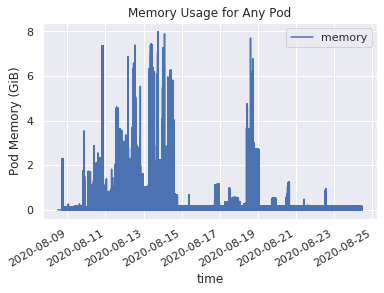

In [19]:
_ = pod_mem_df_formatted.plot(y="memory")
_ = plt.ylabel("Pod Memory (GiB)")
_ = plt.title("Memory Usage for Any Pod")

## CPU

In [20]:
pod_cpu_df = pd.read_csv(pod_cpu_csv_file)
pod_cpu_df.head()

,"Series;""Time"";""Value"""
0,"autohttps-594b9f8865-ggdxp;""2020-08-08T12:00:0..."
1,"autohttps-594b9f8865-ggdxp;""2020-08-08T12:15:0..."
2,"autohttps-594b9f8865-ggdxp;""2020-08-08T12:30:0..."
3,"autohttps-594b9f8865-ggdxp;""2020-08-08T12:45:0..."
4,"autohttps-594b9f8865-ggdxp;""2020-08-08T13:00:0..."


In [21]:
pod_cpu_df.iloc[0,0]

'autohttps-594b9f8865-ggdxp;"2020-08-08T12:00:00-07:00";null'

### CPU Data Cleaning / Formatting

In [22]:
# Split into 3 columns
pod_cpu_df_formatted = pod_cpu_df.iloc[:,0].str.split(";", expand=True)
pod_cpu_df_formatted.columns = ["pod", "time", "cpu"]

# Fix time col formatting and set as index
pod_cpu_df_formatted.loc[:,"time"] = [value[1:][:-7] for value in pod_cpu_df_formatted.loc[:, "time"]]
pod_cpu_df_formatted.loc[:, "time"] = pd.to_datetime(pod_cpu_df_formatted.time, format="%Y-%m-%dT%H:%M:%S")
pod_cpu_df_formatted = pod_cpu_df_formatted.set_index("time")

# Fix numeric column formatting
pod_cpu_df_formatted.loc[:, "cpu"] = pd.to_numeric(pod_cpu_df_formatted.cpu.str.replace("null", "0"))

# Look at the final result
pod_cpu_df_formatted.head()

,pod,cpu
time,,
2020-08-08 12:00:00,autohttps-594b9f8865-ggdxp,0.0
2020-08-08 12:15:00,autohttps-594b9f8865-ggdxp,0.0
2020-08-08 12:30:00,autohttps-594b9f8865-ggdxp,0.0
2020-08-08 12:45:00,autohttps-594b9f8865-ggdxp,0.0
2020-08-08 13:00:00,autohttps-594b9f8865-ggdxp,0.0


### Earliest Data Entry

While the csv file has entries starting April 23rd, the earliest entry that actually has a non-zero value for cpu is on June 7th. The pod listed here is one that helps with HTTPS and was configured on May 14th, so it should have cpu data from May 14th onward. This indicates that Prometheus in our naive configuration stores about two weeks of data. That explains why the data prior to June 7th seems _extremely_ flat.

In [23]:
pod_cpu_df_formatted[pod_cpu_df_formatted.cpu != 0].head(1)

,pod,cpu
time,,
2020-08-08 17:15:00,autohttps-594b9f8865-ggdxp,0.005162


In [24]:
earliest_entry = pd.to_datetime(pod_cpu_df_formatted[pod_cpu_df_formatted.cpu != 0].head(1).index.values, format="%Y-%m-%dT%H:%M:%S")
latest_entry = pd.to_datetime(pod_cpu_df_formatted.tail(1).index.values, format="%Y-%m-%dT%H:%M:%S")
data_retention = latest_entry - earliest_entry
print(data_retention)

TimedeltaIndex(['15 days 18:45:00'], dtype='timedelta64[ns]', freq=None)


### Plot CPU Data

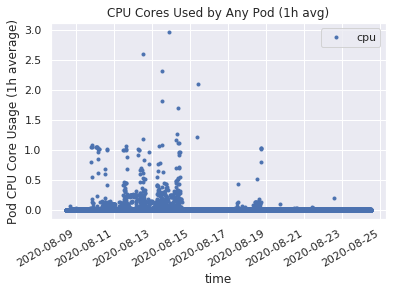

In [25]:
_ = pod_cpu_df_formatted.loc["2020-06-06":].plot(y="cpu", style="b.")
_ = plt.ylabel("Pod CPU Core Usage (1h average)")
_ = plt.title("CPU Cores Used by Any Pod (1h avg)")

### Plot Memory Data over the same time frame

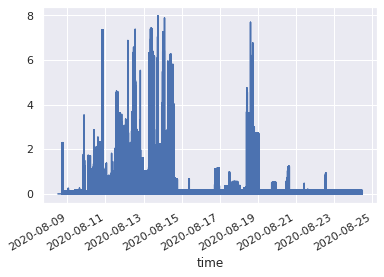

In [26]:
test_df = pod_mem_df_formatted.loc["2020-06-07 12:00:00":,:]
test_df["memory"].plot()

In [27]:
test_df.index

DatetimeIndex(['2020-08-08 12:00:00', '2020-08-08 12:15:00',
               '2020-08-08 12:30:00', '2020-08-08 12:45:00',
               '2020-08-08 13:00:00', '2020-08-08 13:15:00',
               '2020-08-08 13:30:00', '2020-08-08 13:45:00',
               '2020-08-08 14:00:00', '2020-08-08 14:15:00',
               ...
               '2020-08-22 03:00:00', '2020-08-22 03:15:00',
               '2020-08-22 03:30:00', '2020-08-22 03:45:00',
               '2020-08-22 04:00:00', '2020-08-22 04:15:00',
               '2020-08-22 04:30:00', '2020-08-22 04:45:00',
               '2020-08-22 05:00:00', '2020-08-22 05:15:00'],
              dtype='datetime64[ns]', name='time', length=889704, freq=None)

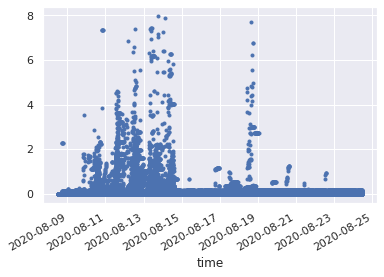

In [28]:
pod_mem_df_formatted.loc["2020-06-07 12:00:00":, "memory"].plot(style="b.")

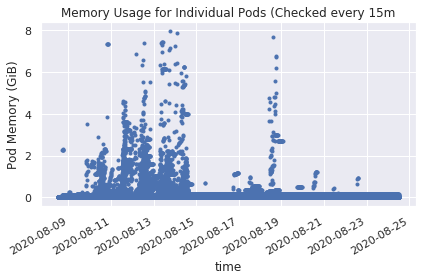

In [29]:
_ = pod_mem_df_formatted.loc["2020-06-07 12:00:00":, "memory"].plot(style="b.")
_ = plt.ylabel("Pod Memory (GiB)")
_ = plt.title("Memory Usage for Individual Pods (Checked every 15m)")
_ = plt.tight_layout()
plt.savefig("ohw_individual_memory_usage.png")

## Next Thoughts

I have the raw data cleaned and formatted so that I have hourly (and in the case of CPU, averaged) data for each pod on the cluster. What should I look at next?
- Number of Users that were on the cluster
- Number of Simultaneous Users
- Highest Average Cpu / Highest Memory Usages among Users
- Compare User Pod Resource Usages with Cluster-side Pod Resource Usages
  
Possible Intermediate Steps to Achieve Easier Answering of the Above Questions:
- Tag Pods with "cluster" or "user" tags

## Tag Pods with "cluster" or "user" tags

In [30]:
pod_mem_df_formatted.head()

,pod,memory
time,,
2020-08-08 12:00:00,aws-node-termination-handler-dd8v2,0.0
2020-08-08 12:15:00,aws-node-termination-handler-dd8v2,0.0
2020-08-08 12:30:00,aws-node-termination-handler-dd8v2,0.0
2020-08-08 12:45:00,aws-node-termination-handler-dd8v2,0.0
2020-08-08 13:00:00,aws-node-termination-handler-dd8v2,0.0


In [31]:
pod_mem_df_formatted.loc[:, "tag"] = ""
pod_mem_df_formatted.head()

,pod,memory,tag
time,,,
2020-08-08 12:00:00,aws-node-termination-handler-dd8v2,0.0,
2020-08-08 12:15:00,aws-node-termination-handler-dd8v2,0.0,
2020-08-08 12:30:00,aws-node-termination-handler-dd8v2,0.0,
2020-08-08 12:45:00,aws-node-termination-handler-dd8v2,0.0,
2020-08-08 13:00:00,aws-node-termination-handler-dd8v2,0.0,


In [32]:
pod_mem_df_formatted.loc[pod_mem_df_formatted.pod.str.contains("jupyter"), "tag"] = "user"
pod_mem_df_formatted.loc[~pod_mem_df_formatted.pod.str.contains("jupyter"), "tag"] = "cluster"
pod_mem_df_formatted.tag.value_counts()

user       540806
cluster    348899
Name: tag, dtype: int64

In [33]:
pod_cpu_df_formatted.loc[pod_cpu_df_formatted.pod.str.contains("jupyter"), "tag"] = "user"
pod_cpu_df_formatted.loc[~pod_cpu_df_formatted.pod.str.contains("jupyter"), "tag"] = "cluster"
pod_cpu_df_formatted.tag.value_counts()

cluster    384250
user       101442
Name: tag, dtype: int64

### Number of Total Users: 66

In [34]:
len(pod_mem_df_formatted[pod_mem_df_formatted.tag == "user"].pod.unique())

65

In [35]:
len(pod_cpu_df_formatted[pod_cpu_df_formatted.tag == "user"].pod.unique())

66

### Highest Number of Concurrent Users

Ah. So the order of the data isn't in order of time, it's in order of pod name and then time. So aarendt has all of their entries time-ordered, then abarciauskas, then alexdebella, etc.

In [37]:
pod_mem_df_formatted[(pod_mem_df_formatted.tag == "user") & (pod_mem_df_formatted.memory != 0)].loc["2020-08-09 10:00:00":"2020-08-24 12:00:00"]

,pod,memory,tag
time,,,
2020-08-11 12:45:00,jupyter-bru-2dod,0.089893,user
2020-08-11 13:00:00,jupyter-bru-2dod,1.057224,user
2020-08-11 13:15:00,jupyter-bru-2dod,1.294247,user
2020-08-11 11:45:00,jupyter-dbrisaro,0.204815,user
2020-08-11 12:00:00,jupyter-dbrisaro,0.206264,user
...,...,...,...
2020-08-13 12:45:00,jupyter-cooleyky,6.154633,user
2020-08-13 13:00:00,jupyter-cooleyky,6.154819,user
2020-08-13 13:15:00,jupyter-cooleyky,6.158859,user


In [38]:
pod_mem_df_formatted[(pod_mem_df_formatted.memory != 0) &
                     (pod_mem_df_formatted.tag == "user")].reset_index().groupby("time").nunique().pod.max()

48

In [39]:
pod_cpu_df_formatted[(pod_cpu_df_formatted.cpu != 0) &
                     (pod_cpu_df_formatted.tag == "user")].reset_index().groupby("time").nunique().pod.max()

56

The datasets give two different numbers. I'm inclined to trust the memory data's number more, as it isn't an hourly average. The CPU data's number can indicate the highest number of concurrent users in an hour, but it doesn't have more granularity than that. However, the memory data is only sampled at hourly intervals, so 76 is the highest number of concurrent users at the top of any hour.

### Number of Concurrent Users over Time

In [40]:
users_over_time_mem = pod_mem_df_formatted[pod_mem_df_formatted.tag == "user"].reset_index().groupby("time").nunique()
users_over_time_cpu = pod_cpu_df_formatted[pod_cpu_df_formatted.tag == "user"].reset_index().groupby("time").nunique()

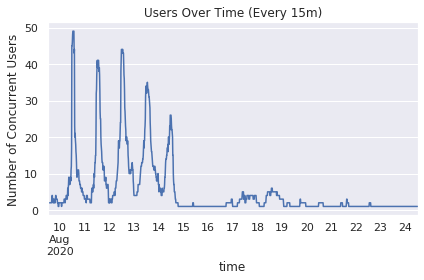

In [42]:
users_plot_0 = users_over_time_mem.loc["2020-08-09 12:00:00":,"memory"].plot(y="memory")
users_plot_0 = plt.title("Users Over Time (Every 15m)")
users_plot_0 = plt.ylabel("Number of Concurrent Users")
users_plot_0 = plt.legend().remove()
users_plot_0 = plt.tight_layout()
plt.savefig("ohw_users_over_time.png")

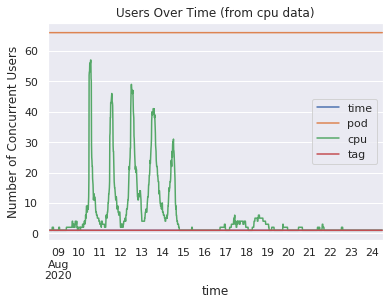

In [43]:
users_plot_1 = users_over_time_cpu.plot()
users_plot_1 = plt.title("Users Over Time (from cpu data)")
users_plot_0 = plt.ylabel("Number of Concurrent Users")

### Highest Average Cpu / Highest Memory Usages among Users

I know that users got up to their allotted four cores on certain tutorials if the other users on their node weren't using at least 2 cores, but this data can't show that information.

In [44]:
pod_mem_df_formatted[pod_mem_df_formatted.tag == "user"].sort_values("memory").tail()

,pod,memory,tag
time,,,
2020-08-13 09:45:00,jupyter-pahdsn,7.439209,user
2020-08-18 15:00:00,jupyter-lowhnn,7.685677,user
2020-08-14 02:30:00,jupyter-lowhnn,7.877388,user
2020-08-13 18:15:00,jupyter-lowhnn,7.973965,user
NaT,jupyter-cooleyky,NaN,user


In [53]:
highest_memory_usage = pod_mem_df_formatted[pod_mem_df_formatted.tag == "user"].sort_values("memory", ascending=False).head(1).values[0,1]
print("The highest value of memory usage among users was %f GB." % (highest_memory_usage))

The highest value of memory usage among users was 7.973965 GB.


In [56]:
pod_cpu_df_formatted[pod_cpu_df_formatted.tag == "user"].sort_values("cpu").tail()

,pod,cpu,tag
time,,,
2020-08-13 12:45:00,jupyter-patrickcgray,1.811432,user
2020-08-15 09:45:00,jupyter-noraloose,2.103674,user
2020-08-13 12:30:00,jupyter-patrickcgray,2.317837,user
2020-08-12 13:15:00,jupyter-singh-2dshikha,2.588373,user
2020-08-13 21:45:00,jupyter-noraloose,2.965996,user


In [58]:
highest_avg_cpu_hour = pod_cpu_df_formatted[pod_cpu_df_formatted.tag == "user"].sort_values("cpu").tail(1).values[0,1]
print("The highest hourly CPU average usage was %f cores." % highest_avg_cpu_hour)

The highest hourly CPU average usage was 2.965996 cores.


### Compare User Pod Resource Usages with Cluster-side Pod Resource Usages

In [59]:
cluster_vs_user_memory = pod_mem_df_formatted.reset_index().groupby(["time", "tag"]).sum()
cluster_vs_user_memory[cluster_vs_user_memory.memory != 0].unstack(level=1).head()

memory          
tag                   cluster      user
time                                   
2020-08-08 17:15:00  0.708920  2.290615
2020-08-08 17:30:00  0.709652  2.290615
2020-08-08 17:45:00  0.710320  2.290760
2020-08-08 18:00:00  0.712204  2.290787
2020-08-08 18:15:00  0.711514  2.295391

In [60]:
first_data_point = cluster_vs_user_memory[cluster_vs_user_memory.memory != 0].index.values[0][0]

In [61]:
cluster_vs_user_memory.unstack(level=1)[first_data_point:].index

DatetimeIndex(['2020-08-08 17:15:00', '2020-08-08 17:30:00',
               '2020-08-08 17:45:00', '2020-08-08 18:00:00',
               '2020-08-08 18:15:00', '2020-08-08 18:30:00',
               '2020-08-08 18:45:00', '2020-08-08 19:00:00',
               '2020-08-08 19:15:00', '2020-08-08 19:30:00',
               ...
               '2020-08-24 09:45:00', '2020-08-24 10:00:00',
               '2020-08-24 10:15:00', '2020-08-24 10:30:00',
               '2020-08-24 10:45:00', '2020-08-24 11:00:00',
               '2020-08-24 11:15:00', '2020-08-24 11:30:00',
               '2020-08-24 11:45:00', '2020-08-24 12:00:00'],
              dtype='datetime64[ns]', name='time', length=1516, freq=None)

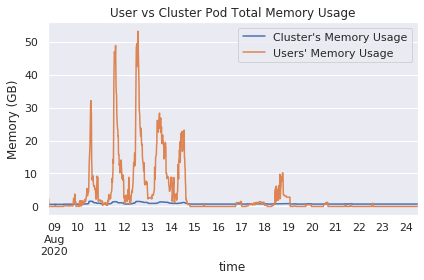

In [62]:
_ = cluster_vs_user_memory.unstack(level=1)[first_data_point:].plot()
_ = plt.ylabel("Memory (GB)")
_ = plt.title("User vs Cluster Pod Total Memory Usage")
_ = plt.legend(["Cluster's Memory Usage", "Users' Memory Usage"])
_ = plt.tight_layout()
plt.savefig("ohw_memory_usage_comparison.png")

In [63]:
cluster_vs_user_cpu = pod_cpu_df_formatted.reset_index().groupby(["time", "tag"]).sum()
cluster_vs_user_cpu[cluster_vs_user_cpu.cpu != 0].unstack(level=1).head()

cpu          
tag                   cluster      user
time                                   
2020-08-08 17:15:00  0.046575  0.071821
2020-08-08 17:30:00  0.038755  0.001679
2020-08-08 17:45:00  0.038263  0.001666
2020-08-08 18:00:00  0.038162  0.002114
2020-08-08 18:15:00  0.039803  0.004866

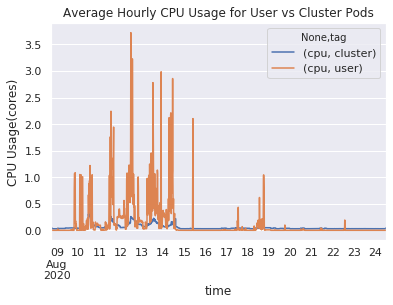

In [64]:
_ = cluster_vs_user_cpu.unstack(level=1)[first_data_point:].plot()
_ = plt.ylabel("CPU Usage(cores)")
_ = plt.title("Average Hourly CPU Usage for User vs Cluster Pods")

This plot seems to indicate that there is a large difference between cluster / user resource consumption when looking at memory or CPU usage. However, it is important to remember that the CPU data is an hourly average, so the data is heavily diluted for users. Users would have their pods perform intense computational tasks, but only for short periods of time. The cluster's pods generally performed at similar levels during the working hours of the day, so an hourly average diluted their data much less.

### Compare 

In [65]:
users_over_time_mem

,time,pod,memory,tag
time,,,,
2020-08-08 12:00:00,1,65,1,1
2020-08-08 12:15:00,1,65,1,1
2020-08-08 12:30:00,1,65,1,1
2020-08-08 12:45:00,1,65,1,1
2020-08-08 13:00:00,1,65,1,1
...,...,...,...,...
2020-08-24 11:00:00,1,65,1,1
2020-08-24 11:15:00,1,65,1,1
2020-08-24 11:30:00,1,65,1,1


In [66]:
cluster_vs_user_memory.unstack(level=1)[first_data_point:]

memory          
tag                   cluster      user
time                                   
2020-08-08 17:15:00  0.708920  2.290615
2020-08-08 17:30:00  0.709652  2.290615
2020-08-08 17:45:00  0.710320  2.290760
2020-08-08 18:00:00  0.712204  2.290787
2020-08-08 18:15:00  0.711514  2.295391
...                       ...       ...
2020-08-24 11:00:00  0.722168  0.000000
2020-08-24 11:15:00  0.722645  0.000000
2020-08-24 11:30:00  0.722397  0.000000
2020-08-24 11:45:00  0.722141  0.000000
2020-08-24 12:00:00  0.721985  0.000000

[1516 rows x 2 columns]